In [23]:
import matplotlib.pyplot as plt
import numpy as np
#Le righe seguenti risolvono il problema che solitamente si ha nell'esecuzione in ambiente LINUX

#In particolare l'esecuzione si blocca perchè il makefile, leggendo il contenuto della variabile d'ambiente BAYESMIX_HOME,
#va a cercare la libreria bayesmixpy e, "seguendo" il percorso contenuto nella variabile, arriva nella cartella build 
#contenuta nella "toolchain" di python installata nel proprio computer(serie di utilità che permottono di far girare il codice python su linux) e non trova nulla 
#Secondo me per uno di questi due motivi :

    #1) Per qualche errore nella fase di costruzione(a.k.a quando si mandano i comandi cmake e make) la cartella non viene riempita correttamente, 
        #per risolvere bisognerebbe riuscire a modificare i makefiles in modo che l'operazione venga effettuata correttamente
    #2) BAYESMIX_HOME dovrebbe contenere l'indirizzo della cartella dove si clona la libreria in quanto,dopo la costruzione, nella sub-cartella python 
        #è possibile vedere questa libreria installata

#Ho preso per buono il secondo e per risolvere ho impostato il path come si legge sotto in modo da obbligare a importare dal path in cui siamo
#chiaramente funziona solo nel mio caso e va riadattato su ogni pc
#è una soluzione temporanea ma almeno va
import sys
sys.path.append("/home/angeloc/BayesianProject/BayesMix/bayesmix/")
from python.bayesmixpy import run_mcmc

from python.bayesmixpy import build_bayesmix

In [24]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
import scipy
from scipy.stats import invwishart
from scipy.stats import beta
from scipy.special import digamma
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib import cm

In [25]:
build_bayesmix(4) 

Building the Bayesmix executable
CMAKE_MODULE_PATH /home/angeloc/BayesianProject/BayesMix/bayesmix
--
-- Fetching bayesmix-dev/math
-- Populating math
CMake Error: Error: generator : Ninja
Does not match the generator used previously: Unix Makefiles
Either remove the CMakeCache.txt file and CMakeFiles directory or choose a different binary directory.
CMake Error at /u/sw/toolchains/gcc-glibc/11.2.0/base/share/cmake-3.20/Modules/FetchContent.cmake:1000 (message):
CMake step for math failed: 1
Call Stack (most recent call first):
/u/sw/toolchains/gcc-glibc/11.2.0/base/share/cmake-3.20/Modules/FetchContent.cmake:1141:EVAL:2 (__FetchContent_directPopulate)
/u/sw/toolchains/gcc-glibc/11.2.0/base/share/cmake-3.20/Modules/FetchContent.cmake:1141 (cmake_language)
/u/sw/toolchains/gcc-glibc/11.2.0/base/share/cmake-3.20/Modules/FetchContent.cmake:1184 (FetchContent_Populate)
cmake/math.cmake:12 (FetchContent_MakeAvailable)
CMakeLists.txt:59 (include)


-- Configuring incomplete, errors occurred!

lib2to3.main: Output in '/home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto/' will mirror the input directory '/home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto' layout.
RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: No changes to /home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto/__init__.py
RefactoringTool: No changes to /home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto/algorithm_id_pb2.py
RefactoringTool: No changes to /home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto/algorithm_params_pb2.py
RefactoringTool: No changes to /home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmixpy/proto/algorithm_state_pb2.py
RefactoringTool: No changes to /home/angeloc/BayesianProject/BayesMix/bayesmix/python/bayesmi

True

Data generation

1.0000000000000002


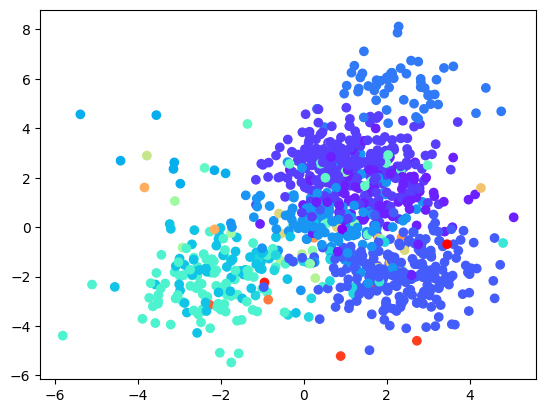

Final number of clusters:  26


In [26]:
seed=2022
np.random.seed(seed)

# Instantiate the first topic
alpha = 5
n = 1000
d = 2

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics =1
mu0 = np.zeros(d)
sigma2=5
Id=np.eye(d)
#sigma0 = np.identity(d)

#cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, sigma2*Id)

mus = [mu1]
#covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    #new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=sigma2*Id)
    mus.append(new_mu)
    #covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.sum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=Id)
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]
datapoints=jnp.array(datapoints)

plt.scatter(xs, ys, color=cs)
plt.show()
print('Final number of clusters: ',len(mus))

MODEL IMPLEMENTATION
We start implementing the base case in which G0 is a normal with 0 mean and fixed covariance structure = sigma0*Identity and alpha is fixed =1.

## The Bayesian Model

## Modelling choices

We consider a mixture of bivariate normals, with unknown mean and covariance matrix. As a prior for the mixing measure we consider either a Dirichlet or a Pitman-Yor process with fixed parameters.

The centering measure is a normal-inverse-Wishart distribution, whose parameters are chosen via an empirical Bayesian procedure.

### Fixed hyperparameters

$\alpha = 1$

$(\mu_0, \lambda,sigma0,degree_of_freedom) = ({0,0}, 0.1,Identity,5)$


In [77]:
dp_params = """
fixed_value {
    totalmass: 1.0
}
"""

g0_params = """
fixed_values {
    mean {
        size: 2
        data: 0.0
        data: 0.0
    }
    var_scaling: 0.1
    deg_free: 4
    scale {
        rows: 2
        cols: 2
        data: 1.0
        data: 0.0
        data: 0.0
        data: 1.0
        rowmajor: false
    }
}
"""

neal2_algo = """
algo_id: "Neal2"
rng_seed: 2022
iterations: 3000
burnin: 1000
init_num_clusters: 10
"""

In [68]:
xgrid = np.linspace(0, 6, 50)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
dens_grid = np.hstack([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)])

In [78]:
eval_dens_dp, n_clus, clus_chain, best_clus_dp, chain = run_mcmc(
    "NNW", "DP", datapoints, g0_params, dp_params, neal2_algo, 
    dens_grid, return_chains=True, return_clusters=True, return_num_clusters=True,
    return_best_clus=True)


Running run_mcmc.cc
Creating FileCollector, writing to file: /tmp/tmps72_g7jv/chains.recordio
Initializing... Done
Running Neal2 algorithm with NNW hierarchies, DP mixing...
[============================================================] 100% 12.884s                                          Done
Computing log-density...
Successfully wrote density to /tmp/tmps72_g7jv/eval_dens.csv
Successfully wrote number of clusters to /tmp/tmps72_g7jv/n_clus.csv
Successfully wrote cluster allocations to /tmp/tmps72_g7jv/clus.csv
(Computing mean dissimilarity... Done)
Computing Frobenius norm error...
[============================================================] 100% 12.155s                  Done


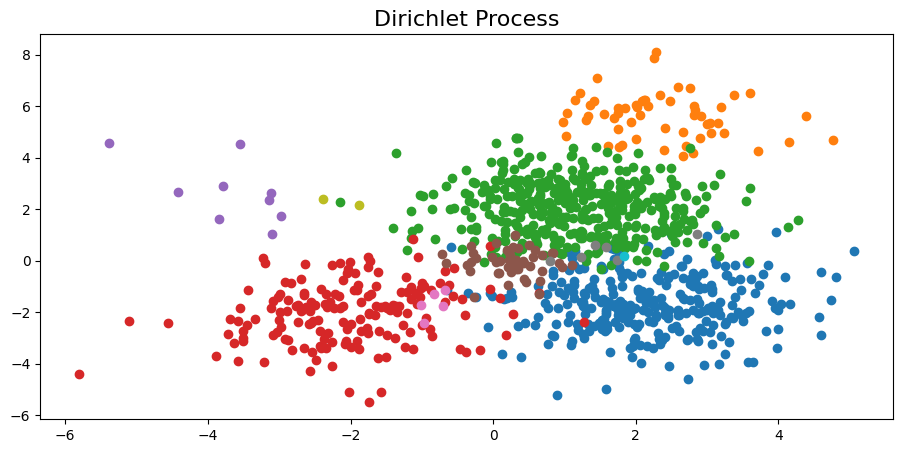

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11, 5))

mean_dens_dp = np.mean(eval_dens_dp, axis=0)

datapoints=np.array(datapoints)

axes.set_title("Dirichlet Process", fontsize=16)
#axes.contour(xgrid, ygrid, mean_dens_dp.reshape(xgrid.shape))
for c in np.unique(best_clus_dp):
    currdata = datapoints[best_clus_dp == c, :]
    axes.scatter(currdata[:, 0], currdata[:, 1])



Extraction of means,variances and phi

In [80]:
#means extraction
means=np.zeros(shape=(ntopics,2))
m=np.zeros(shape=(len(chain),ntopics,2))
for i in range(len(chain)):
    for j in range(len(chain[i].cluster_states)):
        m[i,j,:]=chain[i].cluster_states[j].multi_ls_state.mean.data
means = np.nan_to_num(np.sum(m, axis=0) / np.sum(m != 0, axis=0), nan=0.0)
means = means[~np.all(means == 0, axis=1)]

/tmp/ipykernel_6953/4282595669.py:7: RuntimeWarning: invalid value encountered in divide
  means = np.nan_to_num(np.sum(m, axis=0) / np.sum(m != 0, axis=0), nan=0.0)


In [81]:
#variances extraction
variances=np.zeros(shape=(ntopics,2,2))
v=np.zeros(shape=(len(chain),ntopics,2,2))
for i in range(len(chain)):
    for j in range(len(chain[i].cluster_states)):
        v[i,j,0,0]=1/chain[i].cluster_states[j].multi_ls_state.prec.data[0]
        v[i,j,1,1]=1/chain[i].cluster_states[j].multi_ls_state.prec.data[3]
        #v[i,j,0,1]=v[i,j,1,0]=chain[i].cluster_states[j].multi_ls_state.prec.data[1]
        v[i,j,0,1]=v[i,j,1,0]=0
variances=np.sum(v, axis=0) / np.sum(v != 0, axis=0)
variances = np.nan_to_num(variances, nan=0.0)
variances= variances[:means.shape[0],:,:]

/tmp/ipykernel_6953/3520351229.py:10: RuntimeWarning: invalid value encountered in divide
  variances=np.sum(v, axis=0) / np.sum(v != 0, axis=0)


In [82]:
#cluster assignment extraction
C=np.zeros(shape=(n,ntopics))
C_mcmc=np.zeros(shape=(n,ntopics))
for i in range(n):
    C[i,assignment[i]]=1
    C_mcmc[i,int(best_clus_dp[i])]=1

26
Final number of clusters:  26


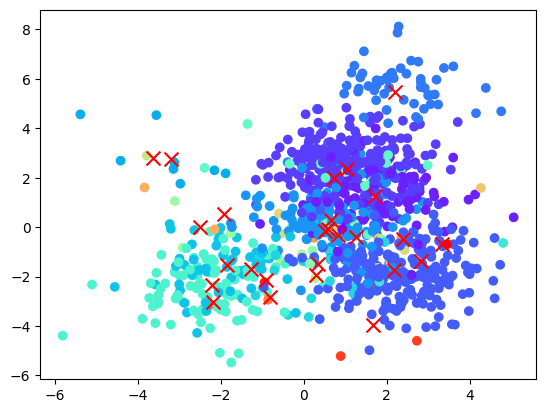

In [83]:
#posterior mean and variance
n_cluster = np.sum(C, axis = 0)
m_post=1/(1+1/sigma2**2)/np.matmul(n_cluster.reshape((ntopics,1)),np.ones(shape=(1,d)))*np.matmul(C.T,datapoints)
s2_post=1/(1+1/sigma2**2)/n_cluster
print(len(m_post))
plt.scatter(xs, ys, color=cs)
print('Final number of clusters: ',len(mus))

for i in range(ntopics):
  plt.scatter(m_post[i,0], m_post[i,1], marker='x', color='red', s=100, label=f'Mean Cluster {i}')

plt.show()

ERROR MEASURE 


In [84]:
from sklearn.metrics import adjusted_rand_score
from scipy.stats import multivariate_normal


def error_measure(m_real,s2_real,clus_real,m_pred,s2_pred,clus_pred,ntopics):
  K=ntopics
  N=clus_pred.shape[0]
  weights1=1/K*np.ones((K,))
  weights2=np.mean(clus_pred,axis=1)
  mix1=0
  mix2=0
  inter=0
  d=m_real.shape[1]
  K_pred=len(m_pred)

  for i in np.arange(K):
    for j in np.arange(K):
      s2_ij=s2_real[i]+s2_real[j]
      mix1+=weights1[i]*weights1[j]*multivariate_normal.pdf(m_real[i,],m_real[j,],s2_ij*np.eye(d))
  for i in np.arange(K_pred):
    for j in np.arange(K_pred):
      s2_ij=s2_pred[i,:]+s2_pred[j,:]
      mix2+=weights2[i]*weights2[j]*multivariate_normal.pdf(m_pred[i,],m_pred[j,],s2_ij)
  for i in np.arange(K):
    for j in np.arange(K_pred):
      s2_ij=s2_real[i]+s2_pred[j]
      inter+=weights1[i]*weights2[j]*multivariate_normal.pdf(m_real[i,],m_pred[j,],s2_ij*np.eye(d))

  error_m_s2=mix1+mix2-2*inter
  clus_real_num=np.empty((N,))
  clus_pred_num=np.empty((N,))
  for i in np.arange(N):
    clus_real_num[i]=np.argmax(clus_real[i,])
    clus_pred_num[i]=np.argmax(clus_pred[i,])

  error_clust=1-adjusted_rand_score(clus_real_num,clus_pred_num)
  diff_clus=K-K_pred
  return error_m_s2,error_clust,diff_clus

In [85]:
#output inattendibile mancano varie cose
error_m_s2,error_clust,diff_clus= error_measure(m_post,s2_post,C,means,variances,C_mcmc,ntopics)
print(error_m_s2)
print(error_clust)
print(diff_clus)

0.16067954039269128
0.5157837211144212
6
